In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU()
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        print_shape = 0
        print_example = 0
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)
        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)

        bottleneck = self.bottleneck(pool2)

        up2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(torch.cat([up2, enc2], dim=1))

        up1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat([up1, enc1], dim=1))
        if print_shape:
          print('x',x[0,0].shape)
          print('enc1',enc1[0,0].shape)
          print('pool1',pool1[0,0].shape)
          print('enc2',enc2[0,0].shape)
          print('pool2',pool2[0,0].shape)
          print('bottleneck',bottleneck.shape)
          print('up2',up2.shape)
          print('dec2',dec2.shape)
          print('up1',up1.shape)
          print('dec1',dec1.shape)

        # print('blurred_blah', type(x))

        if print_example:
          fig, axes = plt.subplots(1, 10, figsize=(50, 5))

          axes[0].imshow(x[0, 0].detach().cpu(), cmap='gray')
          axes[0].set_title("x[0,0]")

          axes[1].imshow(enc1[0, 0].detach().cpu(), cmap='gray')
          axes[1].set_title("enc1[0,0]")

          axes[2].imshow(pool1[0, 0].detach().cpu(), cmap='gray')
          axes[2].set_title("pool1[0,0]")

          axes[3].imshow(enc2[0, 0].detach().cpu(), cmap='gray')
          axes[3].set_title("enc2[0,0]")

          axes[4].imshow(pool2[0, 0].detach().cpu(), cmap='gray')
          axes[4].set_title("pool2[0,0]")

          axes[5].imshow(bottleneck[0, 0].detach().cpu(), cmap='gray')
          axes[5].set_title("bottleneck[0,0]")

          axes[6].imshow(up2[0, 0].detach().cpu(), cmap='gray')
          axes[6].set_title("up2[0,0]")

          axes[7].imshow(dec2[0, 0].detach().cpu(), cmap='gray')
          axes[7].set_title("dec2[0,0]")

          axes[8].imshow(up1[0, 0].detach().cpu(), cmap='gray')
          axes[8].set_title("up1[0,0]")

          axes[9].imshow(dec1[0, 0].detach().cpu(), cmap='gray')
          axes[9].set_title("dec1[0,0]")


          plt.tight_layout()
          plt.show()

        return self.final(dec1)

In [ ]:
kernel_size = 5

In [ ]:
def apply_gaussian_blur(img, sigma, kernel_size):
    device = img.device  # Store the original device
    img = img.squeeze(0).detach().cpu().numpy() #SHape is now 28x28
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigmaX=sigma, sigmaY=sigma, borderType= cv2.BORDER_CONSTANT)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)  # Restore shape with correct device
    img.requires_grad = True
    return img

In [ ]:
transform_clean = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root="./data", train=True, transform=transform_clean, download=True)
test_dataset = MNIST(root="./data", train=False, transform=transform_clean, download=True)

fraction = 1
num_samples = len(train_dataset)
indices = torch.arange(num_samples)[:int(fraction * num_samples)]

sampler = SubsetRandomSampler(indices)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, sampler = sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 448kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.13MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.13MB/s]


In [ ]:
len(train_loader)

1875

In [ ]:
torch.linalg.pinv(torch.tensor([[2,0,0],[0,2,0],[0,0,2]]).type(torch.float32))

tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.5000]])

In [ ]:
#A is identity matrix
sigma1 = 1
sigma2 = 2
x = torch.zeros(kernel_size, kernel_size)
x[int(kernel_size/2), int(kernel_size/2)] = 1
x = x.type(torch.float32)
A_sigma1 = apply_gaussian_blur(x, sigma1, kernel_size)
A_dagger1 = torch.linalg.pinv(A_sigma1)

In [ ]:
def loss_fn(output, target, measurement, blur_operator):
    l_sup = torch.nn.functional.l1_loss(output, target) / (target.norm(p=1) + 1e-8)
    blurred_output = blur_operator(output)
    l_self = torch.nn.functional.l1_loss(measurement, blurred_output) / (measurement.norm(p=1) + 1e-8)
    return l_sup + l_self

In [ ]:
def loss_fn_no_TTT(output, target, measurement, blur_operator):
    l_sup = torch.nn.functional.l1_loss(output, target) / (target.norm(p=1) + 1e-8)
    return l_sup

In [ ]:
torch.tensor([[[1]],[[2]]]).squeeze(1).shape

torch.Size([2, 1])

In [ ]:
def loss_with_A_dagger(output, target, measurement, blur_operator, A_dagger1):
    # output = output
    # target = clean_images
    # measurement = blurred_images

    # loss = loss_fn(outputs, clean_images, blurred_images, lambda x: torch.stack([apply_gaussian_blur(img, sigma=sigma1, kernel_size = kernel_size) for img in x]).cuda())
    kernel_size = A_dagger1.shape[-1]  # Assuming square kernel
    padding = (kernel_size - 1) // 2  # Compute the padding dynamically

    # Reshape to match PyTorch's convolution format: (batch, channels, height, width)
    A_dagger1 = A_dagger1.squeeze(0)
    A_dagger1 = A_dagger1.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, kH, kW)

    A_dagger1 = A_dagger1.cuda()
    # Perform 2D convolution with dynamic padding
    conv_output = torch.stack(([F.conv2d(img.squeeze(0).unsqueeze(0).unsqueeze(0), A_dagger1, padding=padding) for img in output])).squeeze(1)

    # print(conv_output.shape, target.shape)

    l_sup = torch.nn.functional.l1_loss(conv_output, target) / (target.norm(p=1) + 1e-8)
    blurred_output = blur_operator(conv_output)
    l_self = torch.nn.functional.l1_loss(measurement, blurred_output) / (measurement.norm(p=1) + 1e-8)
    return l_sup + l_self

In [ ]:
def compute_accuracy(output, target, threshold=0.05):
    return ((torch.abs(output - target) < threshold).float().mean() * 100).item()

In [ ]:
def compute_psnr(output, target):
    output = output.squeeze()  # Ensure matching shape
    target = target.squeeze()
    mse = torch.nn.functional.mse_loss(output, target)
    return 20 * torch.log10(1.0 / torch.sqrt(mse)).item()

In [ ]:
A_sigma1 * A_dagger1

tensor([[[1.0679e-04, 2.1449e-03, 5.8305e-03, 2.1449e-03, 1.0679e-04],
         [2.1449e-03, 4.3082e-02, 1.1711e-01, 4.3082e-02, 2.1449e-03],
         [5.8305e-03, 1.1711e-01, 3.1833e-01, 1.1711e-01, 5.8305e-03],
         [2.1449e-03, 4.3082e-02, 1.1711e-01, 4.3082e-02, 2.1449e-03],
         [1.0679e-04, 2.1449e-03, 5.8305e-03, 2.1449e-03, 1.0679e-04]]],
       grad_fn=<MulBackward0>)

In [ ]:
#TTT code

model = UNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 7
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    total_accuracy = 0
    total_psnr = 0
    for clean_images, _ in train_loader:
        clean_images = clean_images.cuda()
        blurred_images = torch.stack([apply_gaussian_blur(img, sigma=sigma1, kernel_size = kernel_size) for img in clean_images]).cuda()
        optimizer.zero_grad()
        # plt.imshow(blurred_images[0, 0].detach().cpu().numpy(), cmap='gray')
        # plt.show()
        outputs = model(blurred_images)
        loss = loss_fn_no_TTT(outputs, clean_images, blurred_images, lambda x: torch.stack([apply_gaussian_blur(img, sigma=sigma1, kernel_size = kernel_size) for img in x]).cuda())
        loss.backward()
        optimizer.step()

        total_accuracy += compute_accuracy(outputs, clean_images)
        total_psnr += compute_psnr(outputs, clean_images)
    print(f"Epoch {epoch+1}, Accuracy: {total_accuracy / len(train_loader):.2f}%, PSNR: {total_psnr / len(train_loader):.2f} dB")

# Test-Time Training (TTT)
def test_time_training(image):
    model.train()
    blurred_image = apply_gaussian_blur(image, sigma=sigma2, kernel_size = kernel_size).unsqueeze(0).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    for _ in range(10):
        optimizer.zero_grad()
        output = model(blurred_image)
        blurred_output = apply_gaussian_blur(output, sigma=sigma1, kernel_size=kernel_size).cuda()
        blurred_output.requires_grad = True
        l_self = torch.nn.functional.l1_loss(blurred_image, blurred_output) / (blurred_image.norm(p=1) + 1e-8)
        l_self.backward()
        optimizer.step()
    return model(blurred_image).cpu()

# Inference with TTT
for clean_images, _ in test_loader:
    outputs = [test_time_training(img) for img in clean_images]
    outputs = torch.stack(outputs).squeeze().cuda()
    clean_images = clean_images.squeeze().cuda()
    accuracy = compute_accuracy(outputs, clean_images)
    psnr = compute_psnr(outputs, clean_images)
    print(f"Test-Time Training Accuracy: {accuracy:.2f}%, PSNR: {psnr:.2f} dB")
    break


Epoch 1/7
Epoch 1, Accuracy: 93.97%, PSNR: 32.38 dB
Epoch 2/7
Epoch 2, Accuracy: 98.63%, PSNR: 38.78 dB
Epoch 3/7
Epoch 3, Accuracy: 99.79%, PSNR: 42.31 dB
Epoch 4/7
Epoch 4, Accuracy: 99.91%, PSNR: 44.09 dB
Epoch 5/7
Epoch 5, Accuracy: 99.97%, PSNR: 45.54 dB
Epoch 6/7
Epoch 6, Accuracy: 99.99%, PSNR: 46.94 dB
Epoch 7/7
Epoch 7, Accuracy: 99.99%, PSNR: 47.94 dB
Test-Time Training Accuracy: 73.92%, PSNR: 16.05 dB


Epoch 1/7
Epoch 1, Accuracy: 94.99%, PSNR: 33.54 dB
Epoch 2/7
Epoch 2, Accuracy: 99.51%, PSNR: 40.62 dB
Epoch 3/7
Epoch 3, Accuracy: 99.80%, PSNR: 42.44 dB
Epoch 4/7
Epoch 4, Accuracy: 99.95%, PSNR: 45.13 dB
Epoch 5/7
Epoch 5, Accuracy: 99.97%, PSNR: 45.95 dB
Epoch 6/7
Epoch 6, Accuracy: 99.99%, PSNR: 46.92 dB
Epoch 7/7
Epoch 7, Accuracy: 99.99%, PSNR: 47.70 dB
torch.Size([32, 28, 28])


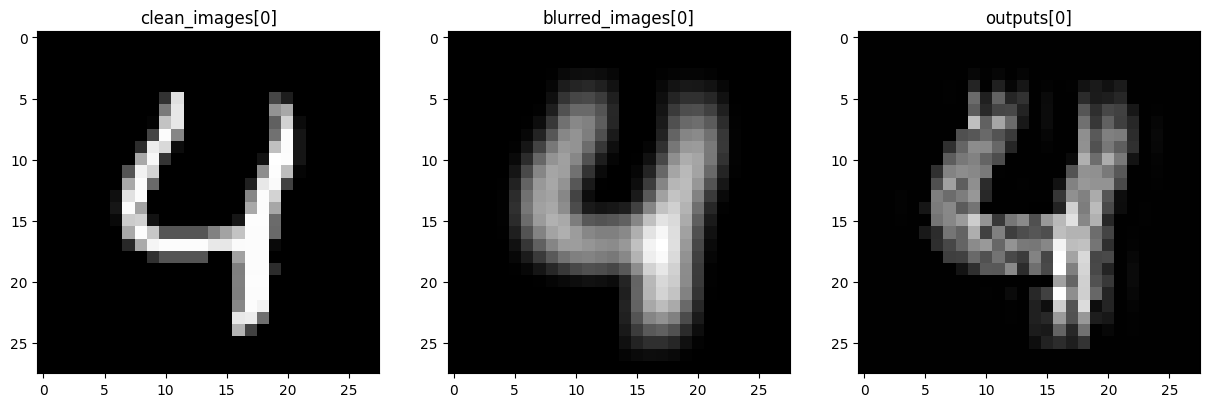

NO Test-Time Training Accuracy: 75.98%, PSNR: 22.06 dB


In [ ]:
#NO TTT Code

model = UNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 7
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    total_accuracy = 0
    total_psnr = 0
    for clean_images, _ in train_loader:
        clean_images = clean_images.cuda()
        blurred_images = torch.stack([apply_gaussian_blur(img, sigma=sigma1, kernel_size=kernel_size) for img in clean_images]).cuda()
        optimizer.zero_grad()
        # plt.imshow(blurred_images[0, 0].detach().cpu().numpy(), cmap='gray')
        # plt.show()
        outputs = model(blurred_images)
        loss = loss_fn_no_TTT(outputs, clean_images, blurred_images, lambda x: torch.stack([apply_gaussian_blur(img, sigma=sigma1) for img in x]).cuda())
        loss.backward()
        optimizer.step()

        total_accuracy += compute_accuracy(outputs, clean_images)
        total_psnr += compute_psnr(outputs, clean_images)
    print(f"Epoch {epoch+1}, Accuracy: {total_accuracy / len(train_loader):.2f}%, PSNR: {total_psnr / len(train_loader):.2f} dB")


# No TTT
for clean_images, _ in test_loader:
    # outputs = [test_time_training(img) for img in clean_images]
    #Without test time training
    blurred_images = torch.stack([apply_gaussian_blur(img, sigma=sigma2, kernel_size=kernel_size) for img in clean_images]).cuda()
    outputs = model(blurred_images.cuda()).squeeze().cuda()
    blurred_images = blurred_images.squeeze().cuda()
    clean_images = clean_images.squeeze().cuda()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    print(blurred_images.shape)
    k=4

    axes[0].imshow(clean_images[k].detach().cpu(), cmap='gray')
    axes[0].set_title("clean_images[0]")

    axes[1].imshow(blurred_images[k].detach().cpu(), cmap='gray')
    axes[1].set_title("blurred_images[0]")

    axes[2].imshow(outputs[k].detach().cpu(), cmap='gray')
    axes[2].set_title("outputs[0]")

    plt.show()

    accuracy = compute_accuracy(outputs, blurred_images)
    psnr = compute_psnr(outputs, blurred_images)
    print(f"NO Test-Time Training Accuracy: {accuracy:.2f}%, PSNR: {psnr:.2f} dB")
    break


In [ ]:
#A dagger code with TTT
#TTT code

model = UNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    total_accuracy = 0
    total_psnr = 0
    for clean_images, _ in train_loader:
        clean_images = clean_images.cuda()
        blurred_images = torch.stack([apply_gaussian_blur(img, sigma=sigma1, kernel_size = kernel_size) for img in clean_images]).cuda()
        optimizer.zero_grad()
        # plt.imshow(blurred_images[0, 0].detach().cpu().numpy(), cmap='gray')
        # plt.show()
        outputs = model(blurred_images)
        loss = loss_with_A_dagger(outputs, clean_images, blurred_images, lambda x: torch.stack([apply_gaussian_blur(img, sigma=sigma1, kernel_size = kernel_size) for img in x]).cuda(), A_dagger1)
        loss.backward(retain_graph=True)
        optimizer.step()

        total_accuracy += compute_accuracy(outputs, clean_images)
        total_psnr += compute_psnr(outputs, clean_images)
    print(f"Epoch {epoch+1}, Accuracy: {total_accuracy / len(train_loader):.2f}%, PSNR: {total_psnr / len(train_loader):.2f} dB")

# Test-Time Training (TTT)
def test_time_training(image):
    model.train()
    blurred_image = apply_gaussian_blur(image, sigma=sigma2, kernel_size = kernel_size).unsqueeze(0).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    for _ in range(10):

        padding = (kernel_size - 1) // 2

        optimizer.zero_grad()
        output = model(blurred_image)
        conv_output =F.conv2d(output, A_dagger1.squeeze(0).unsqueeze(0).unsqueeze(0).cuda(), padding=padding).squeeze(1)

        blurred_output = apply_gaussian_blur(conv_output, sigma=sigma1, kernel_size=kernel_size).cuda()
        blurred_output.requires_grad = True
        blurred_output = blurred_output.unsqueeze(0)
        # print(blurred_image.shape, blurred_output.shape)
        l_self = torch.nn.functional.l1_loss(blurred_image, blurred_output) / (blurred_image.norm(p=1) + 1e-8)
        l_self.backward(retain_graph=True)
        optimizer.step()
    return model(blurred_image).cpu()

# Inference with TTT
for clean_images, _ in test_loader:
    outputs = [test_time_training(img) for img in clean_images]
    outputs = torch.stack(outputs).squeeze().cuda()
    clean_images = clean_images.squeeze().cuda()
    accuracy = compute_accuracy(outputs, clean_images)
    psnr = compute_psnr(outputs, clean_images)
    print(f"Test-Time Training Accuracy: {accuracy:.2f}%, PSNR: {psnr:.2f} dB")
    break


Epoch 1/3
Epoch 1, Accuracy: 77.15%, PSNR: 10.59 dB
Epoch 2/3
Epoch 2, Accuracy: 68.61%, PSNR: 10.62 dB
Epoch 3/3
Epoch 3, Accuracy: 63.94%, PSNR: 10.41 dB
Test-Time Training Accuracy: 70.67%, PSNR: 10.30 dB


Test-Time Training Accuracy: 70.09%, PSNR: 10.34 dB
